In [28]:
import pandas as pd
import json
import numpy as np

```
postprocessing  
intput: df, meta  
output: df  
description:  
하는 것은  
1️⃣ 너무 1초 미만의 등장인물 삭제
2️⃣ 클립  
⭐ 스케일링
```

In [29]:
def postprocessing(df1:pd.DataFrame, meta_info:dict, sec:int=5)->pd.DataFrame:
    # del short length ids, threshold 3sec
    df1 = df1.copy()
    high_rating_id_cnt = 0
    print(f"before filtering id_cnt: {len(df1['track_id'].unique())}")

    for id in df1['track_id'].unique():
        if np.isnan(id): # nan id pass
            continue

        if len(df1[df1['track_id'] == id]) > meta_info['fps']*sec:
            high_rating_id_cnt+=1
        else:
            df1.loc[df1['track_id'] == id,'track_id'] = np.NaN
    
    print(f'after filtering high_rating_id_cnt: {high_rating_id_cnt}')

    # clip
    df1['track_body_xmin'] = df1['track_body_xmin'].clip(0, meta_info['width'])
    df1['track_body_xmax'] = df1['track_body_xmax'].clip(0, meta_info['width'])
    df1['track_body_ymin'] = df1['track_body_ymin'].clip(0, meta_info['height'])
    df1['track_body_ymax'] = df1['track_body_ymax'].clip(0, meta_info['height'])
    
    # scailing
    df1.loc[df1['track_id'].notna(), 'track_body_xmin'] = df1.loc[df1['track_id'].notna(), 'track_body_xmin']/meta_info['width']
    df1.loc[df1['track_id'].notna(), 'track_body_xmax'] = df1.loc[df1['track_id'].notna(), 'track_body_xmin']/meta_info['width']
    df1.loc[df1['track_id'].notna(), 'track_body_ymin'] = df1.loc[df1['track_id'].notna(), 'track_body_xmin']/meta_info['height']
    df1.loc[df1['track_id'].notna(), 'track_body_ymax'] = df1.loc[df1['track_id'].notna(), 'track_body_xmin']/meta_info['height']
    
    postprocessed_df1 = df1
    return postprocessed_df1

```
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

# 원본에 영향을 미치기 때문에 위와같은 오류 문구를 출력함
```

In [30]:
def delete_short_id(df:pd.DataFrame, fps:int, sec:int=5)-> pd.DataFrame:
    df = df.copy()
    for trk_id in df['track_id'].unique():
        # nan id pass
        if np.isnan(trk_id): 
            continue

        # if num of frames over fps*second keep track_id
        if len(df[df['track_id'] == trk_id]) > fps*sec:
            pass
        else:
            df.loc[df['track_id'] == trk_id,'track_id'] = np.NaN
    return df

In [31]:
df

,frame,filename,det_body_xmin,det_body_ymin,det_body_xmax,det_body_ymax,det_conf,track_id,track_body_xmin,track_body_ymin,track_body_xmax,track_body_ymax,track_conf
0,1,000001.jpg,330.34960,535.81116,892.01580,1715.1991,0.940190,0.0,330.349609,535.811157,892.015808,1715.199097,0.940190
1,1,000001.jpg,2020.36360,529.47830,2466.63670,1712.9662,0.920153,1.0,2020.363647,529.478271,2466.636719,1712.966187,0.920153
2,1,000001.jpg,1259.92330,993.80710,1535.52330,1480.1564,0.916883,2.0,1259.923340,993.807129,1535.523315,1480.156372,0.916883
3,1,000001.jpg,1294.27110,770.76355,1545.58510,1409.0521,0.896960,3.0,1294.271118,770.763550,1545.585083,1409.052124,0.896960
4,2,000002.jpg,334.89594,538.94500,892.85345,1713.9077,0.939980,0.0,334.895935,538.945007,892.853455,1713.907715,0.939980
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23475,4679,004679.jpg,2176.08600,561.82050,2819.50120,1859.6080,0.798389,62.0,2176.085938,561.820496,2819.501221,1859.608032,0.798389
23476,4679,004679.jpg,1850.78200,541.75604,2724.28120,1863.5216,0.036080,NaN,NaN,NaN,NaN,NaN,NaN
23477,4679,004679.jpg,1124.39280,506.63516,1980.34690,1902.0281,0.027902,NaN,NaN,NaN,NaN,NaN,NaN
23478,4679,004679.jpg,548.77790,520.27040,1253.49460,1894.3192,0.022052,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
temp = pd.DataFrame([1,2,3,4])
temp["hello"] = [1]*4
temp

,0,hello
0,1,1
1,2,1
2,3,1
3,4,1


```
Index(['frame', 'filename', 'det_body_xmin', 'det_body_ymin', 'det_body_xmax',
       'det_body_ymax', 'det_conf', 'track_id', 'track_body_xmin',
       'track_body_ymin', 'track_body_xmax', 'track_body_ymax', 'track_conf'],
      dtype='object')
```

In [33]:
def get_max_iou(pred_boxes, gt_boxes):
    """
    calculate the iou multiple pred_boxes and 1 gt_box (the same one)
    pred_boxes: multiple predict  boxes coordinate
    gt_box: ground truth bounding  box coordinate
    return: the max overlaps about pred_boxes and gt_box
    """

    # print('pb 1', type(pred_boxes), pred_boxes[0:41][0])
    tp_num = 0
    # 1. calculate the inters coordinate

    for boxes in pred_boxes:
        for gt_box in gt_boxes:
            gt_box = list(map(int, gt_box))

            ixmin = np.maximum(boxes[0], gt_box[0])
            ixmax = np.minimum(boxes[2], gt_box[2])
            iymin = np.maximum(boxes[1], gt_box[1])
            iymax = np.minimum(boxes[3], gt_box[3])


            iw = np.maximum(abs(ixmax - ixmin) + 1., 0.)
            ih = np.maximum(abs(iymax - iymin) + 1., 0.)

    # 2.calculate the area of inters
            inters = iw * ih

    # 3.calculate the area of union
    #         uni = ((pred_boxes[:, 2] - pred_boxes[:, 0] + 1.) * (pred_boxes[:, 3] - pred_boxes[:, 1] + 1.) +
    #            (gt_box[2] - gt_box[0] + 1.) * (gt_box[3] - gt_box[1] + 1.) -inters)
            uni = ((boxes[2] - boxes[0] + 1.) * (boxes[3] - boxes[1] + 1.) +
                              (gt_box[2] - gt_box[0] + 1.) * (gt_box[3] - gt_box[1] + 1.) - inters)

            # print('uni', uni)
            # print(inters)

            iou = inters / uni
            # print('iou',iou)
            if iou > 0.55:
                tp_num += 1

    return tp_num

In [34]:
def count_overlap(df:pd.DataFrame)->pd.DataFrame:
    overlap_list = []
    frame_list = []
    for frame_num in sorted(df['frame'].unique()): #iter each frame
        overlap_cnt = 0 # counting per id
        one_frame_df = df[df['frame'] == frame_num] # get one frame
        frame_list.append(one_frame_df)

    for frame in frame_list:
        frame
        break

    return frame

In [35]:
df = pd.read_csv("/opt/ml/final-project-level3-cv-04/test_PATH/postprocessed_df1.csv", index_col=0)
df = count_overlap(df)

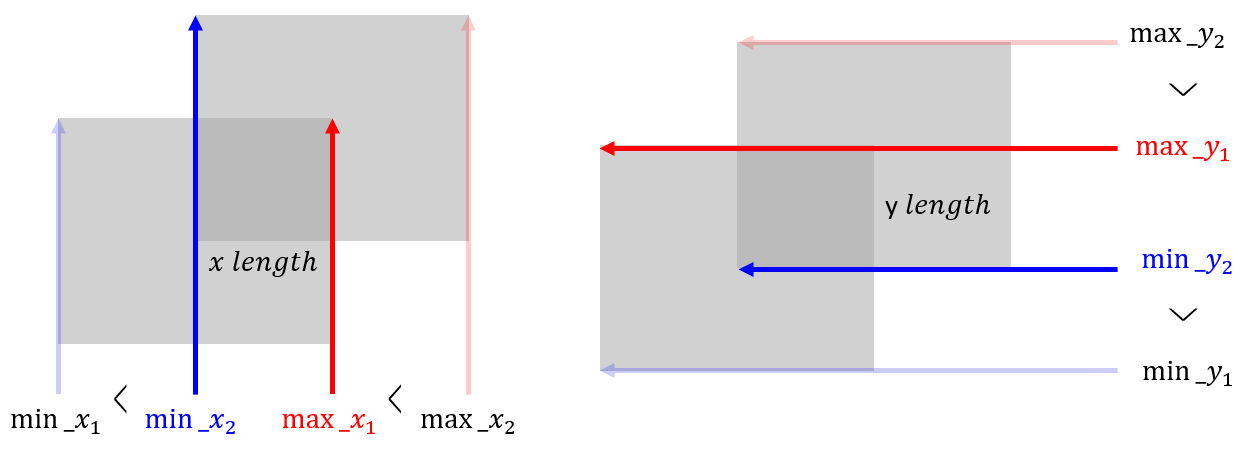

In [36]:
df

,frame,filename,det_body_xmin,det_body_ymin,det_body_xmax,det_body_ymax,det_conf,track_id,track_body_xmin,track_body_ymin,track_body_xmax,track_body_ymax,track_conf
0,1,000001.jpg,330.3496,535.81116,892.0158,1715.1991,0.940190,0.0,330.349609,535.811157,892.015808,1715.199097,0.940190
1,1,000001.jpg,2020.3636,529.47830,2466.6367,1712.9662,0.920153,1.0,2020.363647,529.478271,2466.636719,1712.966187,0.920153
2,1,000001.jpg,1259.9233,993.80710,1535.5233,1480.1564,0.916883,2.0,1259.923340,993.807129,1535.523315,1480.156372,0.916883
3,1,000001.jpg,1294.2711,770.76355,1545.5851,1409.0521,0.896960,3.0,1294.271118,770.763550,1545.585083,1409.052124,0.896960


In [39]:
import iou
np_df = df[['track_body_xmin', 'track_body_ymin', 'track_body_xmax', 'track_body_ymax']].to_numpy()

In [43]:

# print(np_df)

for idx, i in enumerate(range(4),1):
    query_box = np_df[:][i] # pred_bbox gt_bbox

    print(query_box)
    other_boxes = np.expand_dims(query_box, axis=0)
    
    target_box = np.expand_dims(query_box, axis=0) # unsqueeze
    for bbox in other_boxes:
        bbox = np.expand_dims(bbox, axis=0)
        out = iou.iou(target_box, bbox)
        print(idx, out)
    break

[ 330.34960938  535.81115723  892.01580811 1715.19909668]
1 [1.]


In [ ]:
np_df

array([[ 330.34960938,  535.81115723,  892.01580811, 1715.19909668],
       [2020.36364746,  529.47827148, 2466.63671875, 1712.96618652],
       [1259.92333984,  993.80712891, 1535.52331543, 1480.15637207],
       [1294.27111816,  770.7635498 , 1545.58508301, 1409.05212402]])

In [ ]:
import cv2
import matplotlib.pyplot as plt


BLUE_COLOR = (255,0,0)
def draw_bboxes(img_path:str, np_coordinates:np.array):
    img = cv2.imread(img_path)
    for bbox in np_coordinates:
        xmin, ymin, xmax, ymax = bbox
        print(xmin)
        cv2.rectangle(img, pt1=(int(xmin), int(ymin)), pt2=(int(xmax), int(ymax)), color = BLUE_COLOR, thickness=5)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

330.349609375
2020.3636474609373
1259.92333984375
1294.2711181640625


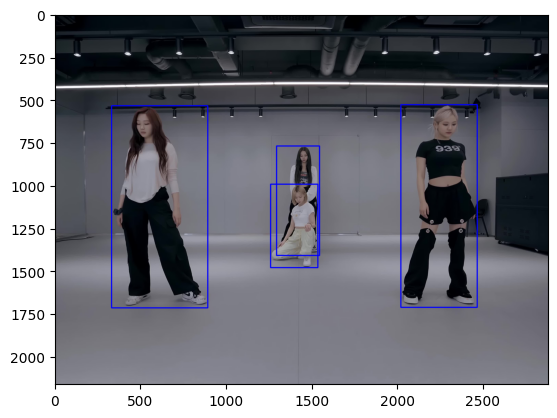

In [ ]:
draw_bboxes("/opt/ml/final-project-level3-cv-04/data/20230122_1907/000001.jpg", np_df)

In [ ]:
current_imgid = 0
img = cv2.imread(filename="/opt/ml/final-project-level3-cv-04/data/20230122_1907/000001.jpg")
for ann in data['annotations']:
    bbox = list(map(int, ann['bbox']))
    boxsize = bbox[2]
    if boxsize < 100:
        boxsize = 100
    if boxsize > 500:
        boxsize = 500
    label = ann['category_id']
    bbox = [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]
    if ann['image_id'] != current_imgid:
        cv.imwrite(os.path.join(destination_dir, f'{str(current_imgid).zfill(4)}_annotated.jpg'), img=img)
        current_imgid = ann['image_id']
        img = cv.imread(filename=base+str(current_imgid).zfill(4)+'.jpg')
    
    cv.rectangle(img = img, pt1=bbox[:2], pt2=bbox[2:], color = color[label], thickness=5)
    if bbox[2] > 980:
        bbox[2] = 980
    if bbox[3] < 40:
        bbox[3] = 40
    cv.putText(img=img, text=LABEL_NAME[label], org=(bbox[0], bbox[1]-10), fontFace=cv.FONT_HERSHEY_SIMPLEX,
               fontScale=boxsize/250, color=(255,255,255), thickness=boxsize//150)

cv.imwrite(os.path.join(destination_dir, f'{str(current_imgid).zfill(4)}_annotated.jpg'), img=img)